In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
from google.colab import files
uploaded = files.upload()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Saving training.1600000.processed.noemoticon.csv to training.1600000.processed.noemoticon.csv


In [ ]:
# ✅ 3. Read and Prepare the Data
df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding='ISO-8859-1')
df.columns = [col.lower().strip() for col in df.columns]

# Find text and label columns dynamically
text_col = [col for col in df.columns if "text" in col][0]
label_col = [col for col in df.columns if "polarity" in col][0]
df = df[[text_col, label_col]].dropna()
# ✅ 4. Clean the Text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", '', text)
    text = re.sub(r"@\w+|#\w+", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"\d+", '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df[text_col] = df[text_col].apply(clean_text)
# ✅ 5. Map labels: 0 (negative), 4 (positive)
df[label_col] = df[label_col].map({0: 0, 4: 1})
df = df[df[label_col].isin([0, 1])]  # Remove any unexpected values

In [ ]:
# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 70% for training, 30% for testing
split_index = int(0.7 * len(df))
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]


In [4]:
# ✅ 7. Tokenization and Padding
MAX_WORDS = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df[text_col])

X_train = tokenizer.texts_to_sequences(train_df[text_col])
X_test = tokenizer.texts_to_sequences(test_df[text_col])

X_train = pad_sequences(X_train, maxlen=MAX_LEN)
X_test = pad_sequences(X_test, maxlen=MAX_LEN)

y_train = train_df[label_col].values
y_test = test_df[label_col].values


NameError: name 'train_df' is not defined

In [ ]:
from tensorflow.keras.utils import to_categorical

# One-hot encode labels
y_train = to_categorical(train_df[label_col].values, num_classes=2)
y_test = to_categorical(test_df[label_col].values, num_classes=2)

# Build the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
    LSTM(lstm_units, return_sequences=True),
    SimpleRNN(rnn_units),
    Dropout(dropout_rate),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(2, activation='softmax')  # 2 classes now
])
model.build(input_shape=(None, input_length))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=128)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,334,754 (5.09 MB)

 Trainable params: 1,334,754 (5.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5735/5735 ━━━━━━━━━━━━━━━━━━━━ 826s 143ms/step - accuracy: 0.8339 - loss: 0.3848 - val_accuracy: 0.8583 - val_loss: 0.3295
Epoch 2/10
5735/5735 ━━━━━━━━━━━━━━━━━━━━ 843s 140ms/step - accuracy: 0.8675 - loss: 0.3141 - val_accuracy: 0.8609 - val_loss: 0.3246
Epoch 3/10
5735/5735 ━━━━━━━━━━━━━━━━━━━━ 892s 146ms/step - accuracy: 0.8780 - loss: 0.2920 - val_accuracy: 0.8625 - val_loss: 0.3241
Epoch 4/10
5735/5735 ━━━━━━━━━━━━━━━━━━━━ 859s 145ms/step - accuracy: 0.8873 - loss: 0.2715 - val_accuracy: 0.8613 - val_loss: 0.3315
Epoch 5/10
5735/5735 ━━━━━━━━━━━━━━━━━━━━ 858s 144ms/step - accuracy: 0.8991 - loss: 0.2474 - val_accuracy: 0.8556 - val_loss: 0.3486
Epoch 6/10
5735/5735 ━━━━━━━━━━━━━━━━━━━━ 828s 144ms/step - accuracy: 0.9098 - loss: 0.2238 - val_accuracy: 0.8547 - val_loss: 0.3671
Epoch 7/10
5735/5735 ━━━━━━━━━━━━━━━━━━━━ 826s 138ms/step - accuracy: 0.9191 - loss: 0.2018 - val_accuracy: 0.8523 - val_loss: 0.4034
Epoch 8/10
5735/5735 ━━━━━━━━━━━━━━━━━━━━ 826s 142ms/step - ac

In [ ]:
# 💾 Save the model
from google.colab import drive
drive.mount('/content/drive')  # run this now
model.save('/content/drive/MyDrive/lstm_rnn_sentiment_model.h5')
print("Model saved as lstm_rnn_sentiment_model.h5")

Mounted at /content/drive
Model saved as lstm_rnn_sentiment_model.h5


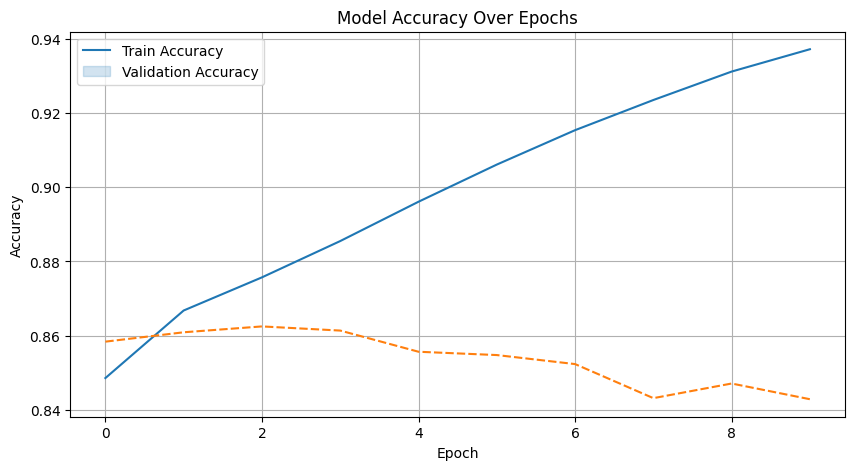

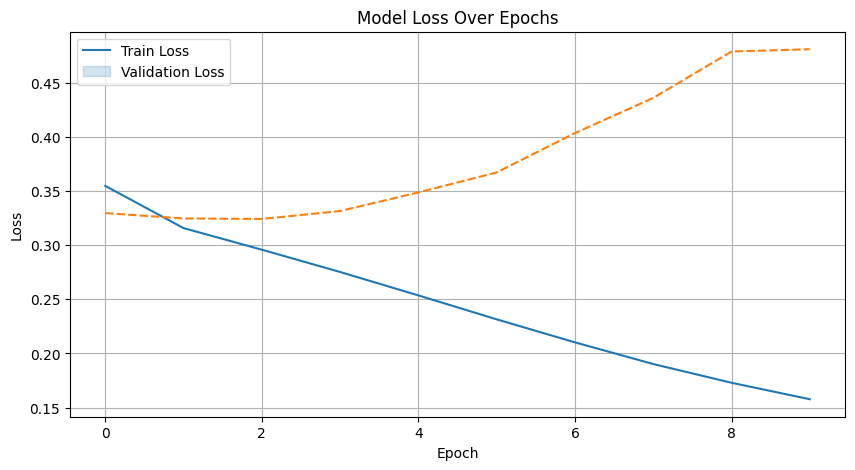

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert training history to DataFrame
history_df = pd.DataFrame(history.history)

# Plot accuracy
plt.figure(figsize=(10, 5))
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])
plt.grid(True)
plt.show()


9831/9831 ━━━━━━━━━━━━━━━━━━━━ 355s 36ms/step


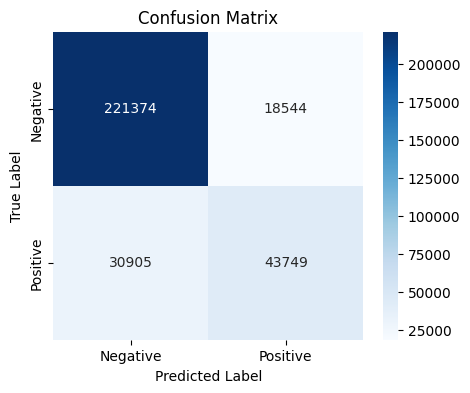

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert one-hot encoded y_test to class labels (0 or 1)
y_test_labels = np.argmax(y_test, axis=1)

# Predict class probabilities and convert to class labels
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_classes)

# Plot confusion matrix with seaborn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


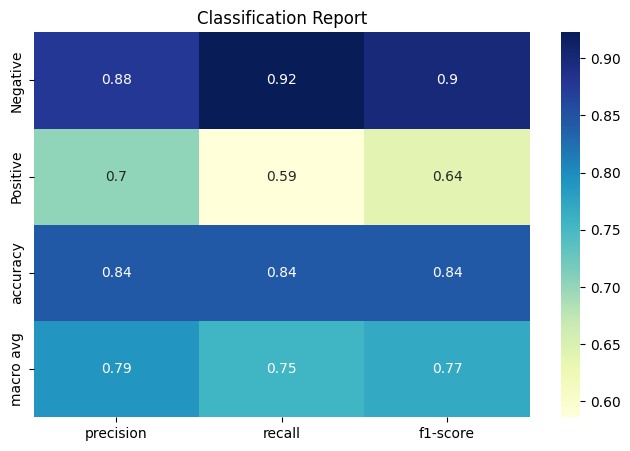

In [ ]:
from sklearn.metrics import classification_report

# ✅ Convert y_test from one-hot to class indices
y_test_labels = np.argmax(y_test, axis=1)

# ✅ Generate classification report
report_dict = classification_report(y_test_labels, y_pred_classes, target_names=["Negative", "Positive"], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# ✅ Plot as heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu")
plt.title("Classification Report")
plt.show()

In [ ]:
# Convert y_test from one-hot to class labels
y_test_labels = np.argmax(y_test, axis=1)

# Find misclassified examples
wrong_preds = np.where(y_pred_classes != y_test_labels)[0]

# Show first 5 misclassified examples
for i in wrong_preds[:5]:
    print(f"\nText: {test_df.iloc[i][text_col]}")
    print(f"Actual: {'Positive' if y_test_labels[i] == 1 else 'Negative'}")
    print(f"Predicted: {'Positive' if y_pred_classes[i] == 1 else 'Negative'}")



Text: usha uthup is singing ente keralam
Actual: Positive
Predicted: Negative

Text: i need help configuring my joomla template
Actual: Negative
Predicted: Positive

Text: i have been jonesing for a cigarette since december rd
Actual: Negative
Predicted: Positive

Text: you can pay for school but you cant buy class
Actual: Positive
Predicted: Negative

Text: yes they are and according to melons are gourds too who knew
Actual: Positive
Predicted: Negative
